In [1]:
import pandas as pd
import numpy as np

In [2]:

data = pd.read_csv("2_min_interval.csv")
new_data = data.iloc[:, 2:]
"""forward fill the missing values"""
new_data = new_data.fillna(method='ffill')
new_data # new_data contain daily price data of these 25 stocks for the past two years

,A,ABC,AIZ,AMD,CAG,CF,CSGP,CTAS,DHR,DVA,...,JBHT,JNPR,LOW,PAYC,STZ,TGT,URI,VICI,VRSN,XOM
0,85.949997,85.080002,132.360001,49.099998,33.630001,46.400002,62.066002,270.790009,155.110001,75.250000,...,117.519997,24.709999,120.459999,271.799988,188.300003,126.070000,168.649994,25.280001,196.729996,70.900002
1,84.570000,84.010002,132.990005,48.599998,33.340000,46.080002,62.619999,269.570007,154.149994,75.080002,...,117.029999,24.340000,119.599998,272.709991,189.529999,124.760002,165.710007,25.299999,200.880005,70.330002
2,84.820000,85.239998,133.110001,48.389999,33.520000,46.000000,62.450001,270.269989,154.610001,75.550003,...,115.000000,24.290001,120.349998,278.089996,190.399994,123.580002,165.380005,25.040001,202.740005,70.870003
3,85.080002,84.629997,132.210007,48.250000,32.320000,45.580002,62.002998,270.070007,156.130005,75.110001,...,117.650002,24.190001,119.629997,279.489990,183.600006,123.800003,165.080002,24.940001,203.210007,70.290001
4,85.919998,85.449997,132.710007,47.830002,31.870001,45.790001,62.537998,275.279999,156.289993,75.529999,...,118.760002,24.110001,121.529999,283.119995,190.289993,123.400002,164.809998,25.100000,204.149994,69.230003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,149.009995,169.270004,122.970001,63.860001,38.759998,89.900002,77.250000,452.500000,258.670013,73.430000,...,176.440002,31.389999,199.149994,303.790009,231.009995,141.350006,350.880005,32.209999,203.429993,105.879997
751,149.229996,170.009995,125.029999,64.519997,38.840000,90.739998,76.889999,457.239990,259.859985,73.760002,...,177.360001,31.670000,201.880005,305.170013,232.410004,143.149994,355.220001,32.669998,203.720001,108.680000
752,149.550003,169.000000,124.570000,63.270000,39.020000,87.599998,76.750000,459.029999,260.880005,73.900002,...,178.220001,31.780001,201.710007,301.619995,232.389999,145.550003,358.679993,32.720001,204.070007,110.190002
753,148.089996,167.360001,123.959999,62.570000,38.650002,86.339996,76.050003,451.040009,259.339996,72.800003,...,174.460007,31.360001,200.059998,302.630005,231.880005,145.800003,351.880005,32.189999,201.130005,108.379997


In [3]:
"""chekc if there is any nan value in the data"""
new_data.isnull().values.any()

import matplotlib.pyplot as plt
%matplotlib ipympl


In [4]:
"""transform the new_data into minute returns"""
numpy_data = new_data.to_numpy()
a = numpy_data.T
x = np.zeros((25, 755))
for i in range(25):
    for j in range(1, len(a[0])):
        x[i][j] = ((a[i][j] - a[i][j - 1]) / a[i][j - 1])


x = 252 * x # annualize the returns

In [5]:
look_back = 75
def get_drift_volatility(x, look_back):
    """get the drift and volatility of the look_back period"""
    drift = []
    volatility = []
    for j in range(len(x[0]) - look_back):
        drift.append(np.mean(x[:, j:j+look_back], axis=1))
        volatility.append(np.cov(x[:, j:j+look_back]))

    drift = np.array(drift)
    volatility = np.array(volatility)
    return drift, volatility

drift, volatility = get_drift_volatility(x, look_back)
print(drift.shape)
print(volatility.shape)



    

(680, 25)
(680, 25, 25)


In [6]:
"""cholesky decomposition"""
def cholesky_decomposition(volatility):
    cholesky = []
    for i in range(len(volatility)):
        cholesky.append(np.linalg.cholesky(volatility[i]))
    cholesky = np.array(cholesky)
    return cholesky

In [7]:
cholesky = cholesky_decomposition(volatility)

In [8]:
import math
d = 25
gamma = 0.01
n = len(drift)
print(n)

A = np.zeros(n)
B = np.zeros(n)



for i in range(n):
    A[i] =  0.5 * np.square(np.linalg.norm(np.matmul(np.linalg.inv(cholesky[i]), drift[i])))
    B[i] = 0.5 * gamma * d - 0.5 * gamma * d * math.log(2 * math.pi * math.e * gamma) + 0.5 * gamma * math.log(np.linalg.det(volatility[i]))

print(A)
print(B)

whatever_dataframe = pd.DataFrame({'A': A, 'B': B})

whatever_dataframe.to_csv("PDE_coefficients.csv")


680
[0.11377843 0.11107379 0.11235592 0.08784999 0.08918812 0.0876869
 0.08182367 0.09218423 0.09434344 0.10870709 0.10555648 0.09267148
 0.09632327 0.09359481 0.0695609  0.06781928 0.07546813 0.07970237
 0.08489389 0.09066629 0.08044986 0.07932058 0.06119747 0.06181395
 0.06129118 0.06694157 0.06783287 0.06887671 0.07776112 0.06994334
 0.06448768 0.05294042 0.04974171 0.04458879 0.04212696 0.0412008
 0.05302731 0.05726419 0.06651224 0.07617954 0.0799482  0.09619257
 0.0906479  0.09160911 0.13674221 0.13107233 0.14655763 0.14665025
 0.15362212 0.18442557 0.18686274 0.21601676 0.20246473 0.20291094
 0.19604975 0.20850788 0.22087772 0.20000424 0.17265326 0.16744024
 0.17345262 0.19907359 0.20064434 0.27048345 0.25964915 0.27155248
 0.26623293 0.24545377 0.23549498 0.24373812 0.24505223 0.26325279
 0.24238625 0.28582039 0.28514291 0.30373797 0.32016954 0.29732854
 0.29714356 0.2782341  0.27822807 0.29634764 0.27232745 0.28271576
 0.28551428 0.28906088 0.2831092  0.31106483 0.31656866 0.31

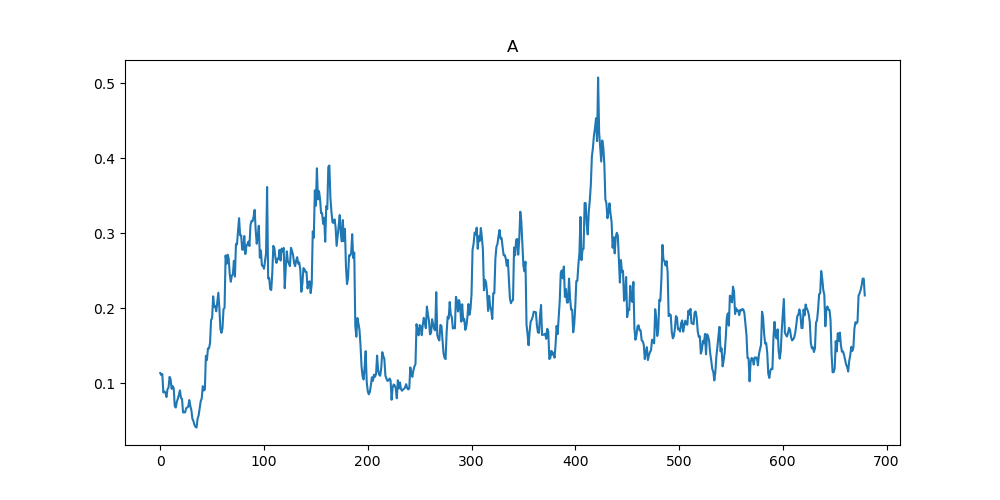

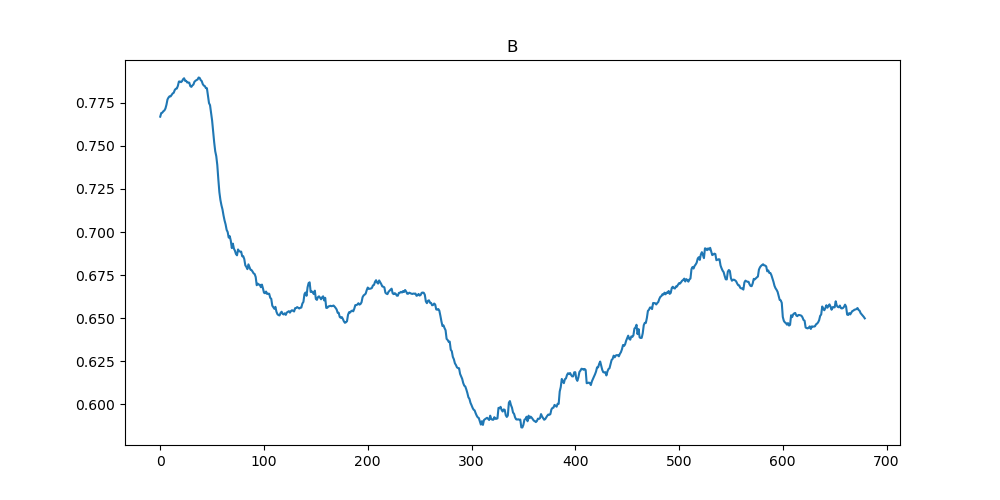

In [9]:


plt.figure(figsize=(10, 5))
plt.plot(A)
plt.title("A")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(B)
plt.title("B")
plt.show()

In [10]:
policy_mean_coeff = []
policy_var_coeff = []

for i in range(n):
    policy_mean_coeff.append(np.dot(-1, np.matmul(np.linalg.inv(volatility[i]), drift[i])))
    policy_var_coeff.append(np.dot(gamma, np.linalg.inv(volatility[i])))

policy_mean_coeff = np.array(policy_mean_coeff)
policy_var_coeff = np.array(policy_var_coeff)

print(policy_mean_coeff.shape)
print(policy_var_coeff.shape)



(680, 25)
(680, 25, 25)


In [11]:

print(np.mean(policy_mean_coeff))
print(np.mean(policy_var_coeff))

-0.0033318193788866328
6.047485138232656e-06


In [12]:
np.save('policy_mean_coeff', policy_mean_coeff)
np.save('policy_var_coeff', policy_var_coeff)

In [13]:
var = np.load('policy_var_coeff.npy')
var
mean = np.load('policy_mean_coeff.npy')
mean

array([[-0.01620581, -0.01145297,  0.02908671, ..., -0.01617239,
        -0.04949928,  0.05420461],
       [ 0.0009117 , -0.00380751,  0.02486603, ..., -0.01481232,
        -0.05585957,  0.05201902],
       [-0.00088708, -0.00577933,  0.02516851, ..., -0.01442582,
        -0.05183486,  0.05167337],
       ...,
       [-0.07301479, -0.0078093 ,  0.05142377, ..., -0.02669045,
        -0.08025279, -0.09783165],
       [-0.07413486, -0.00595406,  0.05098518, ..., -0.02833923,
        -0.08136663, -0.09792716],
       [-0.06021269, -0.01381956,  0.05284706, ...,  0.00246843,
        -0.06628956, -0.12484038]])

In [14]:
holdings = np.random.multivariate_normal(mean[0], var[0])
holdings

array([-0.03047982, -0.00965262,  0.10090017,  0.00121805, -0.04842856,
        0.02114207,  0.02865912, -0.02692391,  0.01732273,  0.00538154,
       -0.03228148,  0.08434681, -0.01216224, -0.00272332,  0.03300168,
        0.037112  , -0.03386149, -0.09652079, -0.03752392,  0.01582362,
       -0.00677139,  0.02229158, -0.03312139, -0.0813314 ,  0.09722822])